In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image

from collections import Counter
from statsmodels.stats.inter_rater import fleiss_kappa
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# Read in the CSV file
file_path = 'annotationsManual_ALL.csv'

data = pd.read_csv(file_path)
print(data.shape[0])
data.head()

38


,Image,FolderNames,Age_A1,Gender_A1,Ethnicity_A1,Age_A2,Gender_A2,Ethnicity_A2,Age_A3,Gender_A3,Ethnicity_A3
0,ffhq_0.png,neutral,Child (2-9),Man,White,Baby (0-1),Woman,Latino/Hispanic,Baby (0-1),Man,Latino/Hispanic
1,ffhq_10.png,happy,Middle-aged Adult (30-49),Woman,White,Middle-aged Adult (30-49),Woman,Asian,Young Adult (20-29),Woman,White
2,ffhq_107.png,neutral,Older Adult (50-65),Woman,White,Older Adult (50-65),Woman,White,Older Adult (50-65),Woman,White
3,ffhq_130.png,neutral,Child (2-9),Woman,Asian,Child (2-9),Woman,Asian,Child (2-9),Woman,Middle Eastern
4,ffhq_15.png,surprise,Young Adult (20-29),Woman,Asian,Young Adult (20-29),Man,White,Adolescent (10-19),Man,White


# Majority Voting to select the labels with Calculate Fleiss' Kappa
Use statsmodels to Calculate Fleiss' Kappa:

Fleiss' Kappa is calculated using the statsmodels library, which accepts a NumPy array of counts.
Interpret Results:

- < 0.0: Poor agreement.
- 0.01–0.20: Slight agreement.
- 0.21–0.40: Fair agreement.
- 0.41–0.60: Moderate agreement.
- 0.61–0.80: Substantial agreement.
- 0.81–1.00: Almost perfect agreement.


In [3]:
def create_count_table(data, attribute_prefix):
    # Collect unique possible values for the attribute
    possible_values = data.filter(like=attribute_prefix).melt()['value'].dropna().unique()
    
    # Initialize the count table with images as the index
    count_table = pd.DataFrame(0, index=data['Image'], columns=possible_values)
    
    # Count occurrences of each label from the annotators
    for column in data.filter(like=attribute_prefix).columns:
        temp_counts = pd.get_dummies(data[column], prefix='', prefix_sep='').groupby(data['Image']).sum()
        count_table = count_table.add(temp_counts, fill_value=0)
    
    return count_table


# Create count tables for Gender, Age, and Ethnicity
gender_counts = create_count_table(data, 'Gender')
age_counts = create_count_table(data, 'Age')
ethnicity_counts = create_count_table(data, 'Ethnicity')
ethnicity_counts.head()

,Asian,Black,Indian,Latino/Hispanic,Middle Eastern,White
Image,,,,,,
ffhq_0.png,0,0,0,2,0,1
ffhq_10.png,1,0,0,0,0,2
ffhq_107.png,0,0,0,0,0,3
ffhq_130.png,2,0,0,0,1,0
ffhq_15.png,1,0,0,0,0,2


In [4]:


# Calculate Fleiss' Kappa for Gender
gender_kappa = fleiss_kappa(gender_counts.to_numpy())
print(f"Fleiss' Kappa for Gender: {gender_kappa}")

# Calculate Fleiss' Kappa for Age
age_kappa = fleiss_kappa(age_counts.to_numpy())
print(f"Fleiss' Kappa for Age: {age_kappa}")

# Calculate Fleiss' Kappa for Ethnicity
ethnicity_kappa = fleiss_kappa(ethnicity_counts.to_numpy())
print(f"Fleiss' Kappa for Ethnicity: {ethnicity_kappa}")


Fleiss' Kappa for Gender: 0.7813299232736574
Fleiss' Kappa for Age: 0.6335415135929462
Fleiss' Kappa for Ethnicity: 0.6207945257555597


##  Intraclass Correlation Coefficient (ICC) 

age groupings are treated as ordinal data (e.g., baby < child < adolescent < young adult, etc.), ICC is more suitable because it accounts for the ordered nature of the data. Fleiss' Kappa treats the categories as nominal, ignoring their inherent order, which might lose some information.

In [5]:

# Step 1: Map Age categories to ordinal values
age_mapping = {
    "Baby (0-1)": 1,
    "Child (2-9)": 2,
    "Adolescent (10-19)": 3,
    "Young Adult (20-29)": 4,
    "Middle-aged Adult (30-49)": 5,
    "Older Adult (50-65)": 6,
    "Elderly (65+)": 7
}

# Convert Age columns to ordinal values
age_data = data[["Age_A1", "Age_A2", "Age_A3"]].replace(age_mapping)

# Step 2: Melt the data into long format
long_data = age_data.reset_index().melt(id_vars="index", 
                                        var_name="Annotator", 
                                        value_name="Age_Group")

# Rename index to Image for clarity
long_data.rename(columns={"index": "Image"}, inplace=True)

# Step 3: Perform one-way ANOVA
model = ols('Age_Group ~ C(Image)', data=long_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Step 4: Calculate ICC
n_subjects = long_data["Image"].nunique()  # Number of images
n_raters = long_data["Annotator"].nunique()  # Number of annotators

ms_between = anova_table['sum_sq']['C(Image)'] / anova_table['df']['C(Image)']
ms_within = anova_table['sum_sq']['Residual'] / anova_table['df']['Residual']

icc = (ms_between - ms_within) / (ms_between + (n_raters - 1) * ms_within)

# Step 5: Output the result
print(f"Intraclass Correlation Coefficient (ICC) for Age Groups: {icc}")


Intraclass Correlation Coefficient (ICC) for Age Groups: 0.9505660642711483


C:\Users\liter\AppData\Local\Temp\ipykernel_10296\343770877.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  age_data = data[["Age_A1", "Age_A2", "Age_A3"]].replace(age_mapping)


We have for each categories substantial agreement.    - These values suggest that annotators have a reasonable level of consistency, particularly for gender, which has the highest agreement.

In [13]:
def majority_vote_with_ambiguity(data, attribute_prefix):
    # Select relevant columns based on the attribute prefix (e.g., Age, Gender, Ethnicity)
    relevant_columns = [col for col in data.columns if col.startswith(attribute_prefix)]
    
    # Create a list to store final labels with ambiguity check
    final_labels = []
    
    for index, row in data[relevant_columns].iterrows():
        # Count the frequency of each label in the row
        label_counts = row.value_counts()
        max_count = label_counts.max()
        
        # Check for ambiguity (more than one label has the same maximum count)
        if (label_counts == max_count).sum() > 1:
            final_labels.append("Ambiguous")  # Flag as ambiguous
        else:
            # Otherwise, select the label with the maximum count
            final_labels.append(label_counts.idxmax())
    
    # Return the final labels as a Series
    return pd.Series(final_labels, index=data.index)

# Apply the majority voting with ambiguity handling
data['Final_Age'] = majority_vote_with_ambiguity(data, 'Age')
data['Final_Gender'] = majority_vote_with_ambiguity(data, 'Gender')
data['Final_Ethnicity'] = majority_vote_with_ambiguity(data, 'Ethnicity')

# Drop all columns that contain 'A1', 'A2', or 'A3' in their names
data = data.drop(columns=data.filter(regex='A[1-3]').columns)



# Save the reset DataFrame to a CSV file
final_labels_file_path = 'FinalManualLabels.csv'  # Update the path as needed
data.to_csv(final_labels_file_path, index=False)

data.head()

,Image,FolderNames,Final_Age,Final_Gender,Final_Ethnicity
0,ffhq_0.png,neutral,Baby (0-1),Man,Latino/Hispanic
1,ffhq_10.png,happy,Middle-aged Adult (30-49),Woman,White
2,ffhq_107.png,neutral,Older Adult (50-65),Woman,White
3,ffhq_130.png,neutral,Child (2-9),Woman,Asian
4,ffhq_15.png,surprise,Young Adult (20-29),Man,White


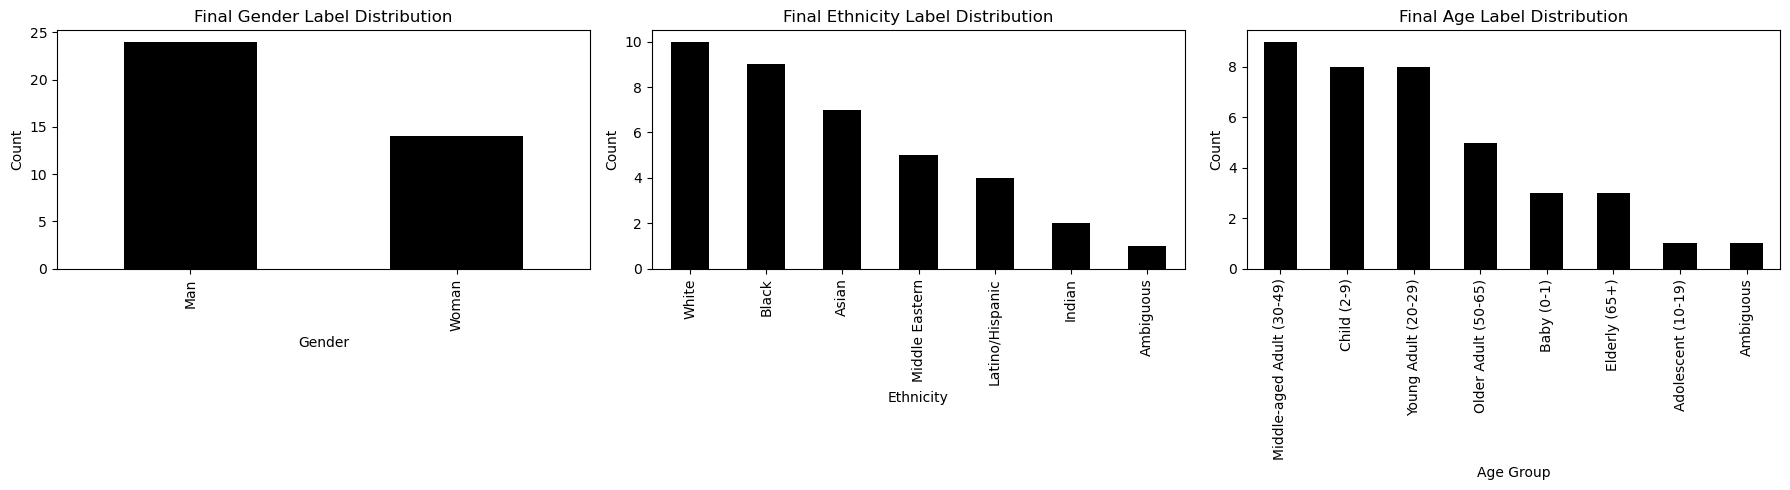

In [7]:
# Plot 1: Bar Plot of Final Labels for Gender, Ethnicity, and Age
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Final Gender Label Distribution
data['Final_Gender'].value_counts().plot(kind='bar', ax=ax[0], color='black')
ax[0].set_title("Final Gender Label Distribution")
ax[0].set_xlabel("Gender")
ax[0].set_ylabel("Count")

# Final Ethnicity Label Distribution
data['Final_Ethnicity'].value_counts().plot(kind='bar', ax=ax[1], color='black')
ax[1].set_title("Final Ethnicity Label Distribution")
ax[1].set_xlabel("Ethnicity")
ax[1].set_ylabel("Count")

# Final Age Label Distribution
data['Final_Age'].value_counts().plot(kind='bar', ax=ax[2], color='black')
ax[2].set_title("Final Age Label Distribution")
ax[2].set_xlabel("Age Group")
ax[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


C:\Users\liter\AppData\Local\Temp\ipykernel_10296\1349536720.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = category_counts.pivot(index='Category', columns='Annotator', values='Count').fillna(0)


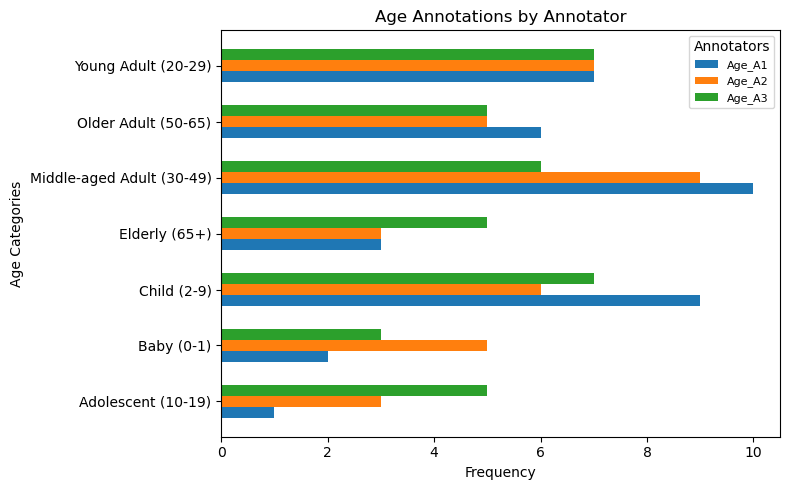

C:\Users\liter\AppData\Local\Temp\ipykernel_10296\1349536720.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = category_counts.pivot(index='Category', columns='Annotator', values='Count').fillna(0)


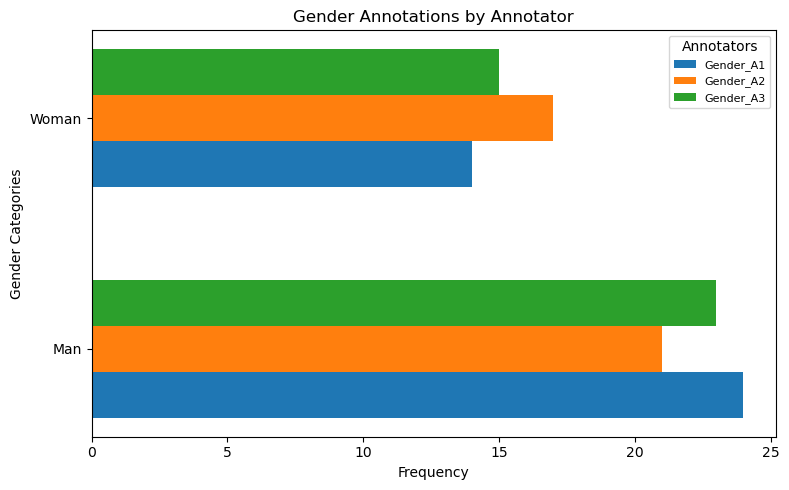

C:\Users\liter\AppData\Local\Temp\ipykernel_10296\1349536720.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = category_counts.pivot(index='Category', columns='Annotator', values='Count').fillna(0)


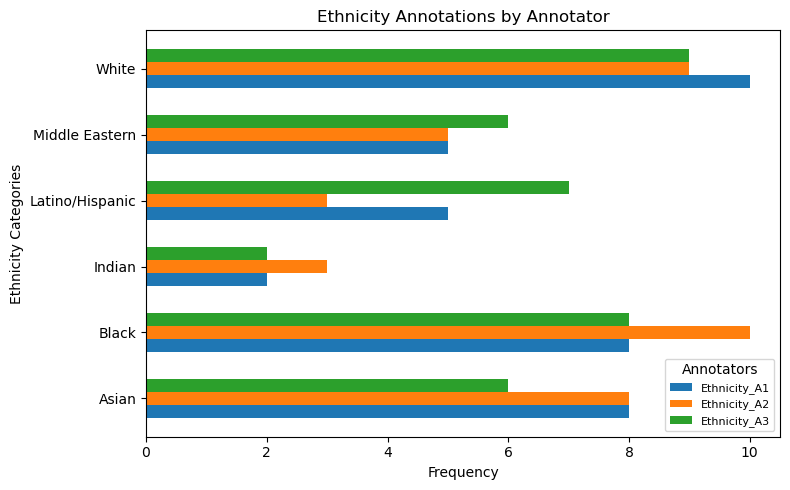

In [10]:
df = data
# Define the annotator columns
annotator_columns = [
    ('age', ['Age_A1', 'Age_A2', 'Age_A3']),
    ('gender', ['Gender_A1', 'Gender_A2', 'Gender_A3']),
    ('ethnicity', ['Ethnicity_A1', 'Ethnicity_A2', 'Ethnicity_A3'])
]

# Function to plot grouped horizontal bar charts for annotations by category and annotator
def plot_grouped_bar_horizontal(attribute, annotator_cols):
    # Count frequencies of each category for each annotator
    category_counts = pd.DataFrame(columns=['Annotator', 'Category', 'Count'])
    for col in annotator_cols:
        counts = df[col].value_counts().reset_index()
        counts.columns = ['Category', 'Count']
        counts['Annotator'] = col
        category_counts = pd.concat([category_counts, counts], ignore_index=True)
    
    # Pivot the data for easier plotting
    pivoted_data = category_counts.pivot(index='Category', columns='Annotator', values='Count').fillna(0)
    annotators = pivoted_data.columns
    
    # Create the grouped horizontal bar chart
    fig, ax = plt.subplots(figsize=(8, 5))
    bar_width = 0.2  # Width of each bar
    y_positions = np.arange(len(pivoted_data.index))  # Positions for categories
    
    # Plot bars for each annotator
    for i, annotator in enumerate(annotators):
        ax.barh(
            y_positions + i * bar_width,  # Shift each group horizontally
            pivoted_data[annotator],
            height=bar_width,
            label=annotator
        )
    
    # Add labels and title
    ax.set_yticks(y_positions + bar_width * (len(annotators) - 1) / 2)
    ax.set_yticklabels(pivoted_data.index)
    ax.set_xlabel("Frequency")
    ax.set_ylabel(f"{attribute.capitalize()} Categories")
    ax.set_title(f"{attribute.capitalize()} Annotations by Annotator")
    ax.legend(title="Annotators", fontsize=8)
    plt.tight_layout()
    plt.show()

# Loop through the attributes and their corresponding columns for horizontal bar charts
for attribute, annotator_cols in annotator_columns:
    plot_grouped_bar_horizontal(attribute, annotator_cols)


#  Ambiguous Cases

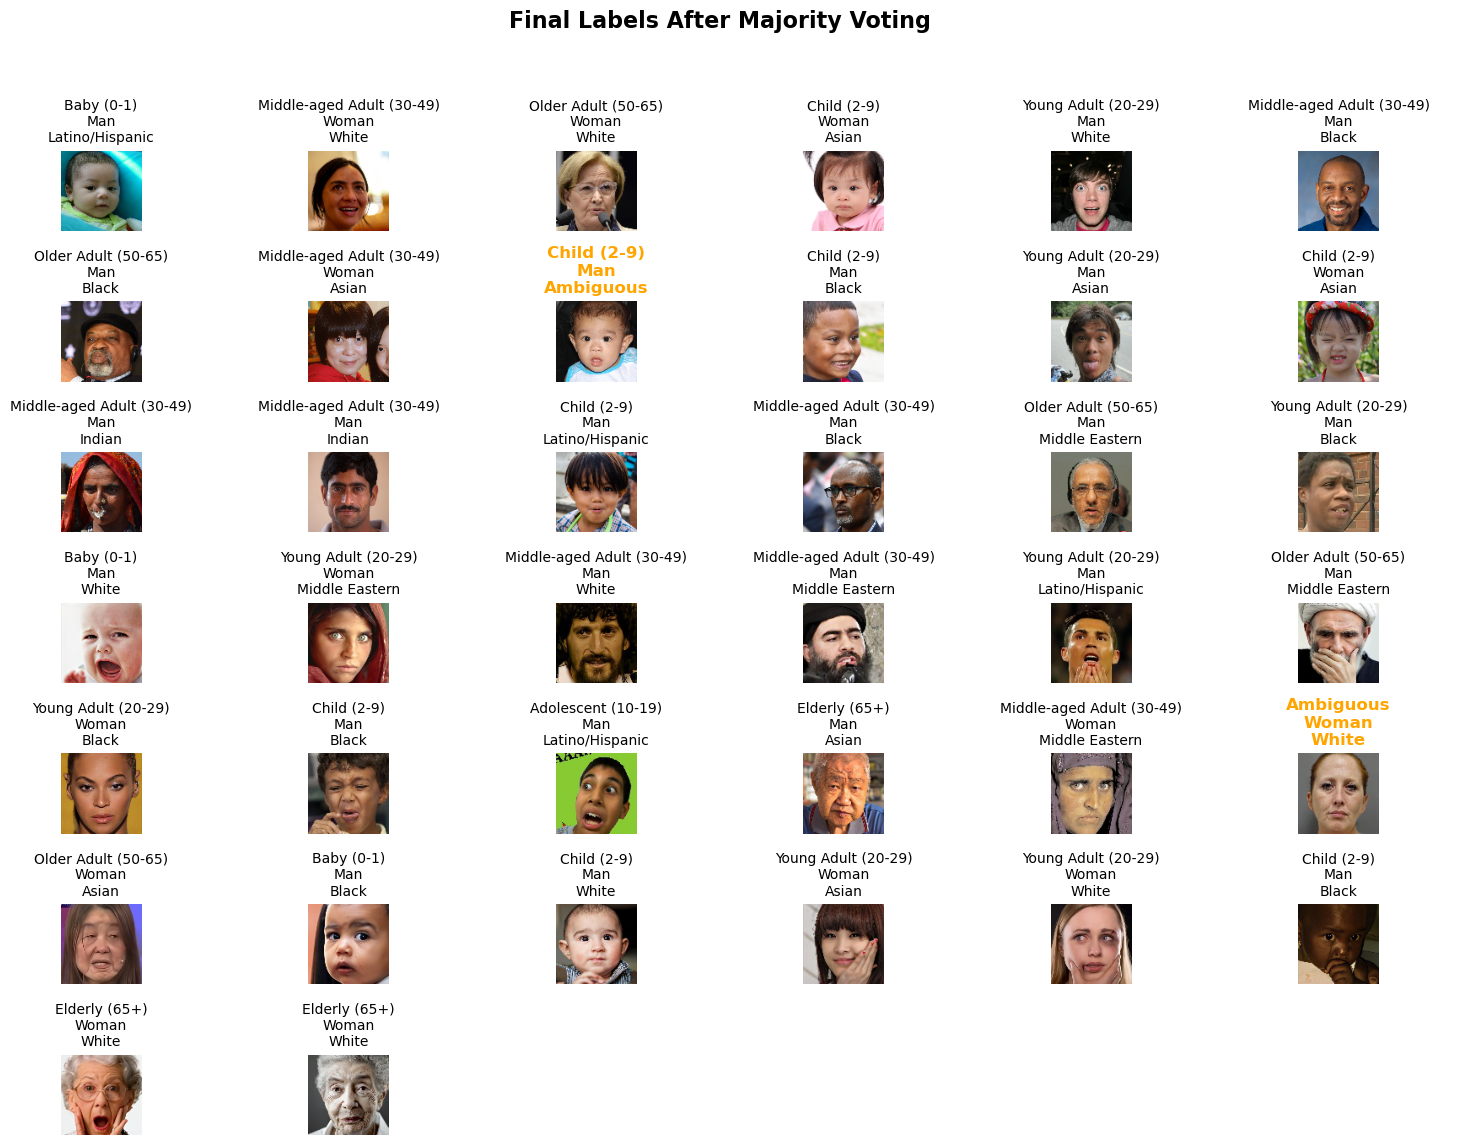

In [11]:
# Set base directory path
base_dir = "../../3_image_datasets/affectnet/SelectionManualAnnotation/AffectNet"  # Replace with the actual path

# Set up the grid dimensions
fig, axes = plt.subplots(7, 6, figsize=(15, 12))  

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Track the index of the image we're displaying
for idx, (index, row) in enumerate(data.iterrows()):
    if idx >= 42:  # Stop after displaying 42 images (6x7 grid)
        break

    image_name = row["Image"]
    folder_name = row["FolderNames"]
    
     # Construct the full image path
    image_path = os.path.join(base_dir, folder_name, image_name)
    
    # Try to open the image file
    if os.path.exists(image_path):
        img = Image.open(image_path)
    else:
        print(f"Image not found: {image_name} in folder {folder_name}")
        continue  # Skip to the next image if the file does not exist

    # Display the image on the grid
    axes[idx].imshow(img)
    axes[idx].axis("off")
    
    # Prepare title with age, gender, and ethnicity information
    age = row["Final_Age"]
    gender = row["Final_Gender"]
    ethnicity = row["Final_Ethnicity"]

    # Check if any label is "Ambiguous" and adjust style accordingly
    if age == "Ambiguous" or gender == "Ambiguous" or ethnicity == "Ambiguous":
        # Highlight ambiguous labels in red with larger font
        title = f"{age}\n{gender}\n{ethnicity}"
        axes[idx].set_title(title, fontsize=12, color="orange", fontweight="bold")
    else:
        # Regular title for non-ambiguous labels
        title = f"{age}\n{gender}\n{ethnicity}"
        axes[idx].set_title(title, fontsize=10, color="black")

# Hide any remaining empty subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

# Add a main title for the entire figure
fig.suptitle("Final Labels After Majority Voting", fontsize=16, fontweight="bold")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the main title
plt.savefig('LabeledPictures.pdf', format='pdf', bbox_inches='tight')  
plt.show()

 - The ambiguous labels were highlighted in the grid plot, indicating cases where the annotators did not agree on a majority label.

In [12]:
# Filter ambiguous cases
ambiguous_cases = data[(data['Final_Age'] == "Ambiguous") |
                       (data['Final_Gender'] == "Ambiguous") |
                       (data['Final_Ethnicity'] == "Ambiguous")]

# Count ambiguous cases by attribute
ambiguous_summary = {
    "Age": (data['Final_Age'] == "Ambiguous").sum(),
    "Gender": (data['Final_Gender'] == "Ambiguous").sum(),
    "Ethnicity": (data['Final_Ethnicity'] == "Ambiguous").sum()
}

print("Ambiguous Cases Summary:")
print(ambiguous_summary)

# Display ambiguous cases for review
ambiguous_cases.head()


Ambiguous Cases Summary:
{'Age': 1, 'Gender': 0, 'Ethnicity': 1}


,Image,FolderNames,Age_A1,Gender_A1,Ethnicity_A1,Age_A2,Gender_A2,Ethnicity_A2,Age_A3,Gender_A3,Ethnicity_A3,Final_Age,Final_Gender,Final_Ethnicity
8,ffhq_30.png,surprise,Child (2-9),Man,Asian,Baby (0-1),Man,Black,Child (2-9),Man,Latino/Hispanic,Child (2-9),Man,Ambiguous
29,image0016204.jpg,sad,Older Adult (50-65),Woman,White,Middle-aged Adult (30-49),Woman,White,Young Adult (20-29),Woman,White,Ambiguous,Woman,White


# Annotation Bias

With a low sample size, it's more likely that the ambiguity stems from inherent challenges in the images themselves rather than systematic biases among annotators. Overlapping characteristics in certain categories (e.g., age or ethnicity) can make annotation inherently subjective. For the woman’s case, subjectivity in age perception plays a major role, while for the baby’s case, the lack of distinct ethnic features contributes to the disagreement.

Since we do not have access to the true labels for these pictures, the best course of action is to accept the final labels, including ambiguous ones, as the ground truth for this dataset. This approach assumes that the observed annotations and their associated majority voting outcomes, even when ambiguous, represent the most reliable consensus available given the data.